<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c3_w3_nlp_overfit_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate --quiet\
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv

!wget --no-check-certificate --quiet\
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt

In [2]:
import json
import csv
import random
import numpy as np
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [3]:
#@title Enable TPU
use_tpu = True #@param ["False", "True"] {type:"raw"}

if use_tpu:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu_spec = tpu.cluster_spec().as_dict()['worker']
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu_spec)
  except ValueError:
    print("ERROR: Not connected to a TPU.")
    raise BaseException("ERROR: Select use_tpu=False.")

INFO:tensorflow:Initializing the TPU system: grpc://10.104.159.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.104.159.2:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: ['10.104.159.2:8470']


In [4]:
embedding_dim = 100
max_length = 16
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
training_size = 160000
test_portion = 0.1
corpus = []


In [5]:
num_sentences = 0
with open("training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        list_items = [row[5], 0 if row[0] == "0" else 1]
        num_sentences += 1
        corpus.append(list_items)

In [6]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [7]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
    sentence, label = corpus[x]
    sentences.append(sentence)
    labels.append(label)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(
    sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

split = int(test_portion * training_size)

training_sequences = np.array(padded[:split])
training_labels = np.array(labels[:split])
test_sequences = np.array(padded[split:])
test_labels = np.array(labels[split:])


In [8]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138655
1


In [9]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word, *coefs = values
        coefs = np.asarray(coefs, dtype="float32")
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [10]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138656


In [11]:
def create_model():
    model = Sequential([
        layers.Embedding(
            vocab_size + 1,
            embedding_dim,
            input_length=max_length,
            weights=[embeddings_matrix],
            trainable=True,
        ),
        layers.Dropout(0.2),
        layers.Conv1D(64, 5, activation="relu"),
        layers.MaxPooling1D(pool_size=4),
        layers.LSTM(64),
        layers.Dense(1, activation="sigmoid"),
    ])
    return model

if use_tpu:
    with tpu_strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13865600  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,930,753
Trainable params: 13,930,753
Non-trainable params: 0
____________________________________________

In [12]:
 len(test_sequences), len(test_labels) 

(144000, 144000)

In [13]:
num_epochs = 50
history = model.fit(
    training_sequences, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(test_sequences, test_labels), 
    verbose=2
)

Epoch 1/50
500/500 - 18s - loss: 0.5883 - accuracy: 0.6853 - val_loss: 0.5370 - val_accuracy: 0.7281
Epoch 2/50
500/500 - 11s - loss: 0.4655 - accuracy: 0.7780 - val_loss: 0.5175 - val_accuracy: 0.7458
Epoch 3/50
500/500 - 13s - loss: 0.3720 - accuracy: 0.8387 - val_loss: 0.5439 - val_accuracy: 0.7397
Epoch 4/50
500/500 - 11s - loss: 0.2459 - accuracy: 0.9019 - val_loss: 0.6288 - val_accuracy: 0.7310
Epoch 5/50
500/500 - 11s - loss: 0.1640 - accuracy: 0.9374 - val_loss: 0.7215 - val_accuracy: 0.7106
Epoch 6/50
500/500 - 11s - loss: 0.1041 - accuracy: 0.9625 - val_loss: 0.8657 - val_accuracy: 0.7086
Epoch 7/50
500/500 - 11s - loss: 0.0765 - accuracy: 0.9720 - val_loss: 0.9463 - val_accuracy: 0.7153
Epoch 8/50
500/500 - 11s - loss: 0.0623 - accuracy: 0.9770 - val_loss: 1.1118 - val_accuracy: 0.7115
Epoch 9/50
500/500 - 11s - loss: 0.0447 - accuracy: 0.9841 - val_loss: 1.0266 - val_accuracy: 0.7103
Epoch 10/50
500/500 - 11s - loss: 0.0391 - accuracy: 0.9848 - val_loss: 1.1971 - val_accura

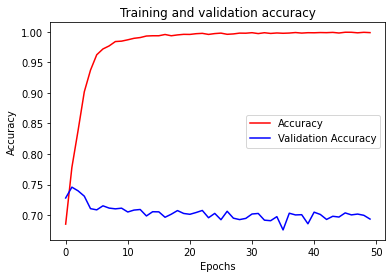

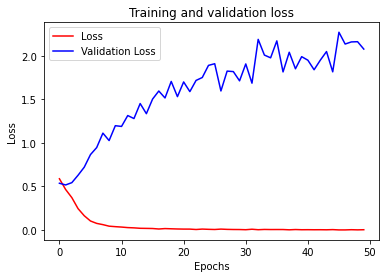

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure();

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure();